### Imports & Installs

In [28]:
import os
import random
import typing as tp
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")


def set_seed(seed):

    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


TEST_SIZE = 0.15
SEED = 560
set_seed(SEED)

### Paths

In [32]:
# TRAIN_PATH = 'drive/MyDrive/Contests/IT_Purple_Hack/data/faiss_imputed_train_final_final.pqt'
# TEST_PATH = 'drive/MyDrive/Contests/IT_Purple_Hack/data/imputed_test.pqt'

TRAIN_PATH = "data/train_cluster_kmeans12.pqt"
TEST_PATH = "data/test_cluster_kmeans12.pqt"

SAMPLE_SUBM_PATH = "submissions/sample_submission.csv"
RESULT_PATH = "submissions/cur.csv"
MODEL_PATH = "models/baseline_model.cbm"
WEIGHTS_PATH = "cluster_weights.xlsx"

Path(MODEL_PATH).parent.mkdir(parents=True, exist_ok=True)

train = pd.read_parquet(TRAIN_PATH)

### Feature Engineering

In [3]:
def generate_agg_features(
    dataset: pd.DataFrame,
    feats_to_agg_list: tp.List[str],
    feats_by_agg_list: tp.List[str],
    build_for_train: bool = True,
    agg_by_3rd_month: bool = True,
    agg_func_list: tp.List[str] = ["max", "mean"],
    test_dataset: pd.DataFrame | None = None,
) -> pd.DataFrame:
    """Generates groupby-features using categorical columns

    Args:
        dataset: train dataset
        feats_to_agg_list: numerical features for aggregations
        feats_by_agg_list: categorical features for aggregations
        build_for_train: flag to create features for train dataset
        agg_by_3rd_month: if True, we calculate groupby features for samples with date=month_3
        agg_func_list: list of aggregating functions
        test_dataset: test dataset (if not None, we merge calculated on train dataset groupby-features to test_dataset)

    Returns:
        test_df: dataset with groupby-features
    """

    if build_for_train:
        train_df = dataset.copy()
        to_agg = (
            dataset[dataset.date == "month_3"].copy()
            if agg_by_3rd_month
            else dataset.copy()
        )
        for agg_feat in feats_by_agg_list:
            grouped = (
                to_agg.groupby(agg_feat)[feats_to_agg_list]
                .agg(agg_func_list)
                .reset_index()
            )
            grouped.columns = [
                (
                    col[0]
                    if col[1] == ""
                    else "agg_{}_{}_{}".format(agg_feat, col[0], col[1])
                )
                for col in grouped.columns
            ]
            train_df = pd.merge(train_df, grouped, on=agg_feat, how="left")

        return train_df

    else:
        test_df = test_dataset.copy()
        for agg_feat in feats_by_agg_list:
            subset_cols = list(dataset.filter(like=("agg_" + agg_feat)).columns) + [
                agg_feat
            ]
            grouped = dataset[subset_cols].groupby(agg_feat).max()
            test_df = pd.merge(test_df, grouped, on=agg_feat, how="left")

        return test_df

In [4]:
def ohe_start_cluster(
    train_dataset: pd.DataFrame, test_dataset: pd.DataFrame
) -> pd.DataFrame:
    """One Hot Encoding for products in "start_cluster" feature

    Args:
        train_dataset: dataset for fitting OneHotEncoder
        test_dataset: dataset that must be encoded by trained OneHotEncoder

    Returns:
        test_df: transformed dataset
    """

    result = test_dataset.copy()

    # Инициализация MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    products_train = (
        train_dataset["start_cluster"]
        .str.lstrip("{")
        .str.rstrip("}")
        .str.replace(" ", "")
        .str.split(",")
    )
    mlb.fit(products_train)

    products_test = (
        result["start_cluster"]
        .str.lstrip("{")
        .str.rstrip("}")
        .str.replace(" ", "")
        .str.split(",")
    )
    one_hot_encoded_labels = mlb.transform(products_test)
    for idx, product in tqdm(enumerate(mlb.classes_)):
        result["start_cluster_product_" + product] = one_hot_encoded_labels[:, idx]

    return result

In [5]:
def make_lags(
    dataset: pd.DataFrame,
    columns_not_to_use: list[str],
    drop_months: bool = False,
    lags: bool = True,
) -> pd.DataFrame:
    """Generates lags features with 1 and 2 shifts

    Args:
        dataset: dataset to be transformed
        columns_not_to_use: name of columns that we do not want to be lagged
        drop_months: if True, we drop samples with date=month_1 and month_2 (in train) and date=month_4 and month_5 (in test)
        lags: if True, we calculate lags

    Returns:
        test_df: transformed dataset with lags
    """

    result = dataset.copy()

    if lags:

        for column in tqdm(result.columns):

            if column not in columns_not_to_use:
                result[column + "_lag1"] = result.groupby("id")[column].shift(1)
                result[column + "_lag2"] = result.groupby("id")[column].shift(2)

    if drop_months:

        result = result.drop(
            result[(result["date"] == "month_1") | (result["date"] == "month_2")].index
        )
        result = result.drop(
            result[(result["date"] == "month_4") | (result["date"] == "month_5")].index
        )

    return result

In [6]:
# Encode embedding clusters to letters, like cluster_0 -> cluster_a, cluster_1 -> cluster_b
# It is needed because, for example, cluster_1 is the prefix if cluster_10 and it breaks our code

cluster_letters = [
    "a",
    "b",
    "c",
    "d",
    "e",
    "f",
    "g",
    "h",
    "i",
    "j",
    "k",
    "l",
    "m",
    "n",
    "o",
    "p",
]
train.rename(
    columns={
        ("cluster_" + str(i)): ("cluster_" + cluster_letters[i]) for i in range(16)
    },
    inplace=True,
)

#### Split

In [7]:
# Get IDs of users for train_dataset and test_datset with target stratification
ids_and_clusters = train[train["date"] == "month_3"][
    ["id", "end_cluster"]
].drop_duplicates()
train_ids, test_ids, _, _ = train_test_split(
    ids_and_clusters["id"],
    ids_and_clusters["end_cluster"],
    stratify=ids_and_clusters["end_cluster"],
    test_size=TEST_SIZE,
    random_state=SEED,
    shuffle=True,
)

dataset_train = train[train["id"].isin(train_ids)]
dataset_val = train[train["id"].isin(test_ids)]

#### Train dataset

In [8]:
# Generate groupby-features for train dataset
feats_to_agg = [
    "balance_amt_min",
    "balance_amt_max",
    "sum_cred_e_oper_3m",
    "sum_deb_h_oper_3m",
    "sum_of_paym_2m",
    "sum_of_paym_1y",
]
feats_by_agg = ["okved", "city", "channel_code", "segment"] + [
    "cluster_" + cluster_letters[i] for i in range(16)
]
agg_func = ["mean"]
dataset_train = generate_agg_features(
    dataset_train,
    feats_to_agg,
    feats_by_agg,
    agg_func_list=agg_func,
)

In [9]:
# Generate OneHotEncoded start_cluster for train dataset
X_train_ohe = ohe_start_cluster(dataset_train, dataset_train)

# Generate lags for train dataset
not_to_lag = (
    list(X_train_ohe.filter(like="agg_").columns)
    + ["id", "date", "end_cluster"]
    + ["cluster_" + cluster_letters[i] for i in range(16)]
)
X_train_lagged = make_lags(
    X_train_ohe, columns_not_to_use=not_to_lag, drop_months=True, lags=True
)

0it [00:00, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

In [10]:
X_train_lagged[
    [
        "id",
        "date",
        "start_cluster",
        "start_cluster_lag1",
        "start_cluster_lag2",
        "start_cluster_product_α",
        "start_cluster_product_α_lag1",
        "start_cluster_product_α_lag2",
    ]
].head(10)

,id,date,start_cluster,start_cluster_lag1,start_cluster_lag2,start_cluster_product_α,start_cluster_product_α_lag1,start_cluster_product_α_lag2
2,0,month_3,"{α, γ}","{α, γ}","{α, γ}",1,1.0,1.0
5,1,month_3,{other},{other},{other},0,0.0,0.0
8,2,month_3,{α},{α},{α},1,1.0,1.0
11,3,month_3,{α},{α},{α},1,1.0,1.0
14,4,month_3,{α},{α},{α},1,1.0,1.0
17,5,month_3,{α},{},{},1,0.0,0.0
20,6,month_3,"{α, γ}","{α, γ}","{α, γ}",1,1.0,1.0
23,7,month_3,{α},{α},{α},1,1.0,1.0
26,8,month_3,"{α, γ}","{α, γ}","{α, γ}",1,1.0,1.0
29,9,month_3,{α},{α},{α},1,1.0,1.0


In [11]:
X_train, y_train = (
    X_train_lagged.drop(columns=["end_cluster"]),
    X_train_lagged["end_cluster"],
)

In [12]:
# Get features that show changing of start_cluster between month_1, month_2 and month_3
X_train["changed_m1_m2"] = (
    X_train["start_cluster_lag2"] != X_train["start_cluster_lag1"]
) * 1
X_train["changed_m2_m3"] = (
    X_train["start_cluster_lag1"] != X_train["start_cluster"]
) * 1
X_train["changed_m1_m3"] = (
    X_train["start_cluster_lag2"] != X_train["start_cluster"]
) * 1

#### Val dataset

In [13]:
# Generate groupby-features for val dataset
dataset_val = generate_agg_features(
    dataset_train,
    feats_to_agg,
    feats_by_agg,
    build_for_train=False,
    agg_func_list=agg_func,
    test_dataset=dataset_val,
)

In [14]:
# Generate OneHotEncoded start_cluster for val dataset
X_val_ohe = ohe_start_cluster(dataset_train, dataset_val)

# Generate lags for val dataset
not_to_lag = (
    list(X_val_ohe.filter(like="agg_").columns)
    + ["id", "date", "end_cluster"]
    + ["cluster_" + cluster_letters[i] for i in range(16)]
)
X_val_lagged = make_lags(
    X_val_ohe, columns_not_to_use=not_to_lag, drop_months=True, lags=True
)

0it [00:00, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

In [15]:
X_val, y_val = X_val_lagged.drop(columns=["end_cluster"]), X_val_lagged["end_cluster"]

In [16]:
# Get features that show changing of start_cluster between month_1, month_2 and month_3
X_val["changed_m1_m2"] = (
    X_val["start_cluster_lag2"] != X_val["start_cluster_lag1"]
) * 1
X_val["changed_m2_m3"] = (X_val["start_cluster_lag1"] != X_val["start_cluster"]) * 1
X_val["changed_m1_m3"] = (X_val["start_cluster_lag2"] != X_val["start_cluster"]) * 1

### Fit model

In [17]:
cat_cols = [
    "channel_code",
    "city",
    "city_type",
    "okved",
    "segment",
    "start_cluster",
    "index_city_code",
    "ogrn_month",
    "ogrn_year",
]

# Create array of categorical columns names for Catboost
cat_cols_lagged = []
for col in cat_cols:
    cat_cols_lagged.append(col)
    cat_cols_lagged.append(col + "_lag1")
    cat_cols_lagged.append(col + "_lag2")

cat_cols_lagged += ["cluster_" + cluster_letters[i] for i in range(16)]

X_train = X_train.drop(columns=["id", "date"])
X_val = X_val.drop(columns=["id", "date"])

# We fill NaNs by zero because NaNs appear due to new users and zeros describe them better than other numbers
X_train.fillna("0", inplace=True)
X_train[cat_cols_lagged] = X_train[cat_cols_lagged].astype("category")
X_train[X_train.dtypes[X_train.dtypes == "object"].index] = X_train[
    X_train.dtypes[X_train.dtypes == "object"].index
].astype(float)

# We fill NaNs by zero because NaNs appear due to new users and zeros describe them better than other numbers
X_val.fillna("0", inplace=True)
X_val[cat_cols_lagged] = X_val[cat_cols_lagged].astype("category")
X_val[X_val.dtypes[X_val.dtypes == "object"].index] = X_val[
    X_val.dtypes[X_val.dtypes == "object"].index
].astype(float)

In [18]:
X_train.shape

(170000, 448)

In [19]:
X_val.shape

(30000, 448)

In [20]:
params_cat = {
    "cat_features": cat_cols_lagged,
    "n_estimators": 1000,
    "task_type": "GPU",
}

model = CatBoostClassifier(**params_cat)
model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True)


# validate
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(
        y_true, y_pred, labels=labels, multi_class="ovr", average=None
    )
    return sum(weights * classes_roc_auc)


cluster_weights = pd.read_excel(WEIGHTS_PATH).set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.176647
0:	learn: 1.5833827	test: 1.5818757	best: 1.5818757 (0)	total: 66.5ms	remaining: 1m 6s
1:	learn: 1.4035809	test: 1.4023176	best: 1.4023176 (1)	total: 127ms	remaining: 1m 3s
2:	learn: 1.2817445	test: 1.2806667	best: 1.2806667 (2)	total: 187ms	remaining: 1m 2s
3:	learn: 1.1945835	test: 1.1938568	best: 1.1938568 (3)	total: 244ms	remaining: 1m
4:	learn: 1.1287161	test: 1.1279385	best: 1.1279385 (4)	total: 306ms	remaining: 1m
5:	learn: 1.0791574	test: 1.0786070	best: 1.0786070 (5)	total: 378ms	remaining: 1m 2s
6:	learn: 1.0420882	test: 1.0414947	best: 1.0414947 (6)	total: 434ms	remaining: 1m 1s
7:	learn: 1.0101880	test: 1.0096105	best: 1.0096105 (7)	total: 487ms	remaining: 1m
8:	learn: 0.9852004	test: 0.9850448	best: 0.9850448 (8)	total: 539ms	remaining: 59.3s
9:	learn: 0.9642414	test: 0.9643629	best: 0.9643629 (9)	total: 593ms	remaining: 58.7s
10:	learn: 0.9463324	test: 0.9470633	best: 0.9470633 (10)	total: 649ms	remaining: 58.3s
11:	learn: 0.9296356	test: 0.9

In [21]:
# Calculate weighted_roc_auc score on validation dataset
y_pred_proba = model.predict_proba(X_val)
weighted_roc_auc(y_val, y_pred_proba, model.classes_, weights_dict)

0.9125527741886946

In [22]:
# Calculate accuracy score on validation dataset
y_pred = model.predict(X_val)
accuracy_score(y_val, y_pred)

0.7326333333333334

### Confusion matrix

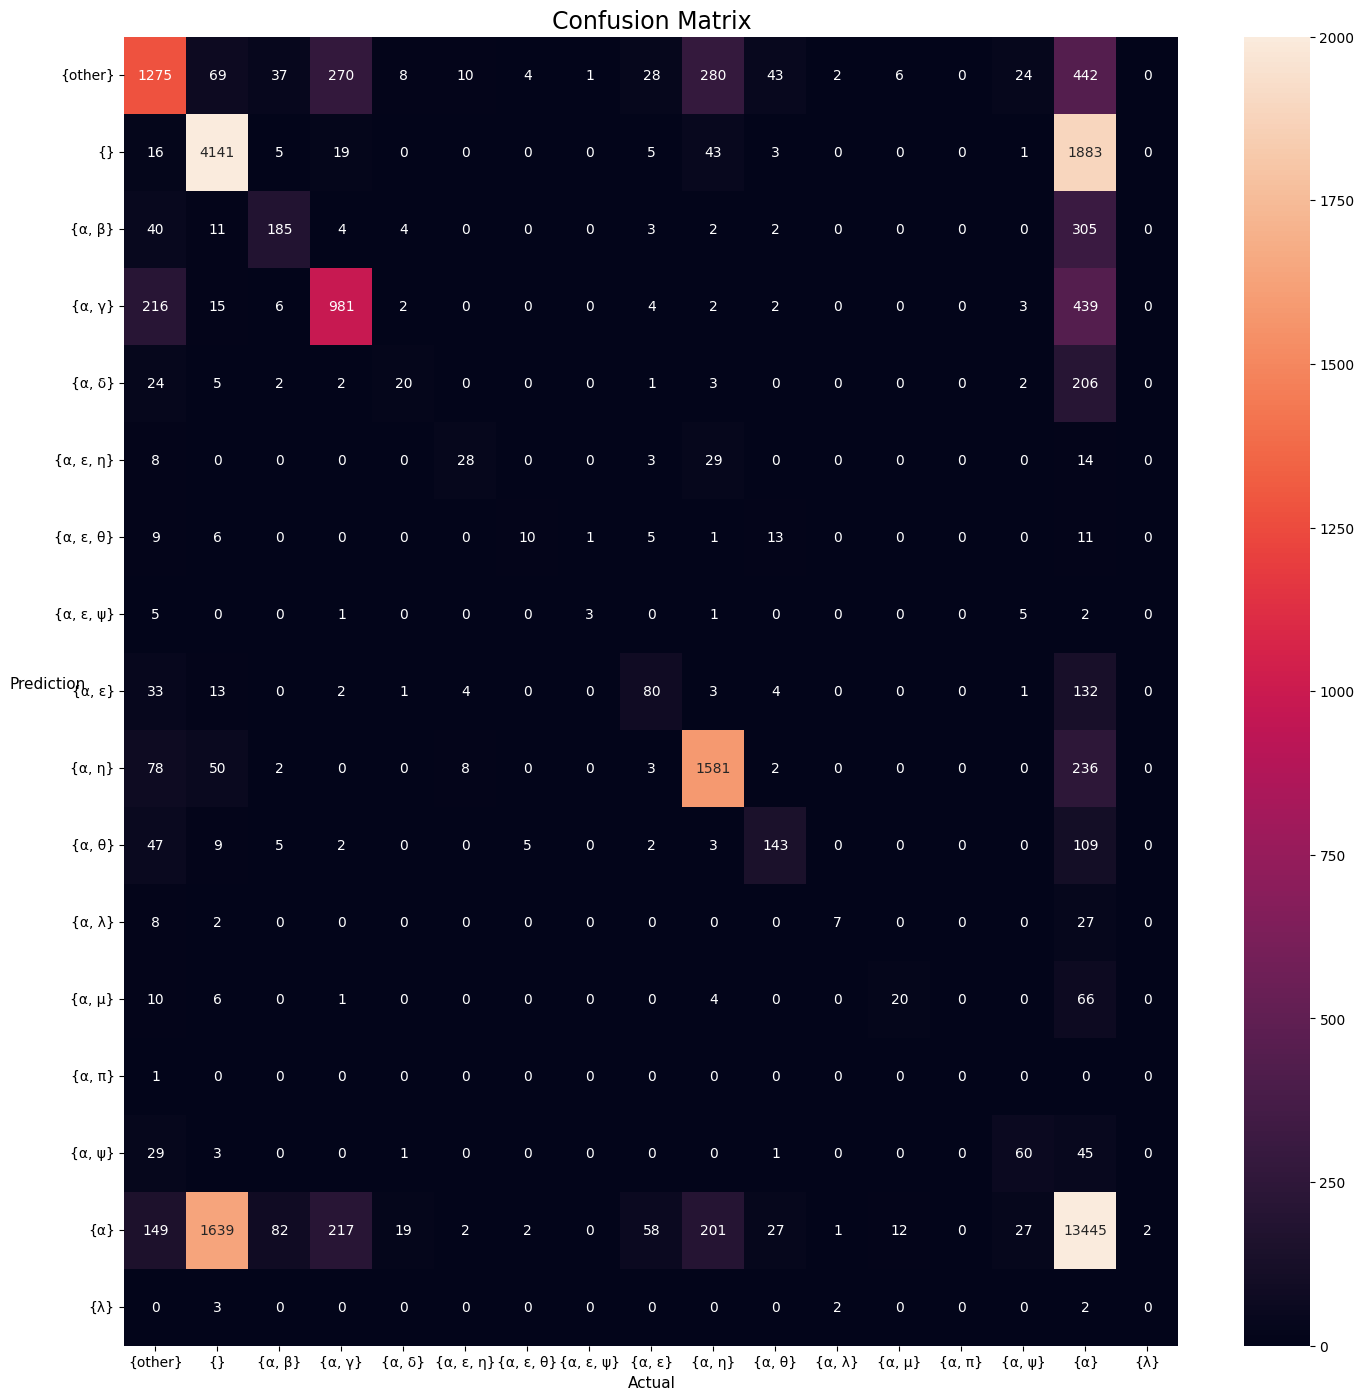

In [23]:
# Create confusion matrix

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(17, 17))
sns.heatmap(
    cm,
    annot=True,
    fmt="g",
    xticklabels=np.unique(y_val.ravel()),
    yticklabels=np.unique(y_val.ravel()),
    vmin=0,
    vmax=2000,
)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.ylabel("Prediction", fontsize=11, rotation=0)
plt.xlabel("Actual", fontsize=11)
plt.title("Confusion Matrix", fontsize=17)
plt.show()

In [24]:
def plot_feature_importance(importance, names, model_type):

    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Create a DataFrame using a Dictionary
    data = {"feature_names": feature_names, "feature_importance": feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=["feature_importance"], ascending=False, inplace=True)
    fi_df = fi_df.iloc[:40]

    # Define size of bar plot
    plt.figure(figsize=(10, 8))
    # Plot Searborn bar chart
    sns.barplot(x=fi_df["feature_importance"], y=fi_df["feature_names"])
    # Add chart labels
    plt.title(model_type + "FEATURE IMPORTANCE")
    plt.xlabel("FEATURE IMPORTANCE")
    plt.ylabel("FEATURE NAMES")

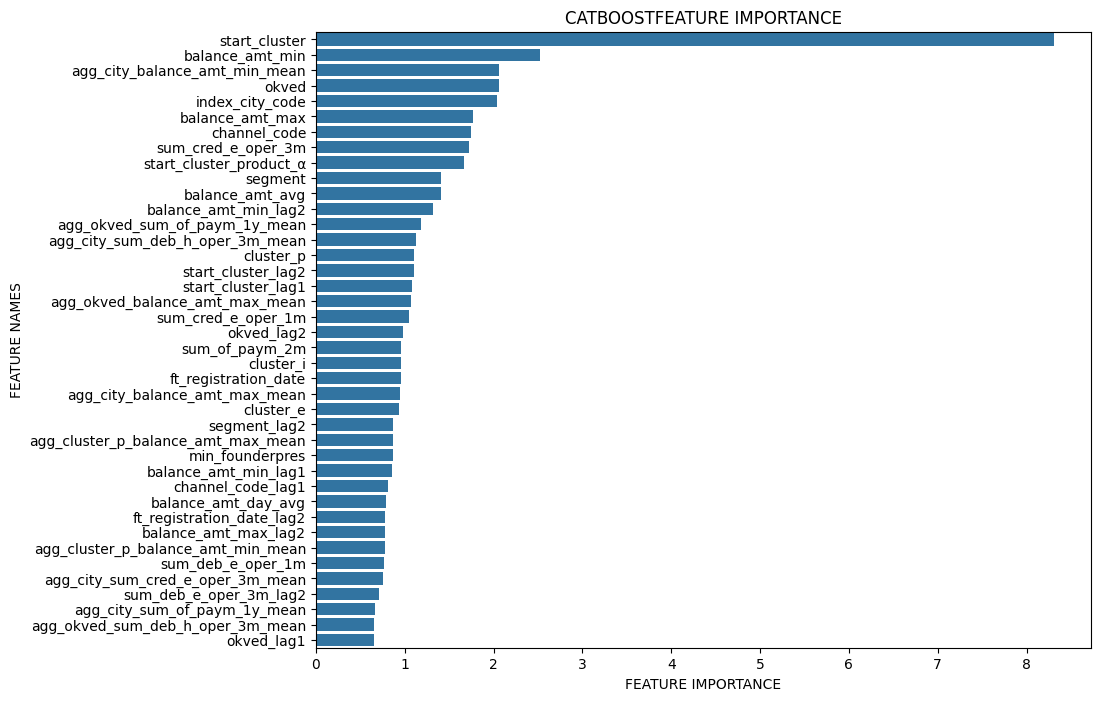

In [25]:
# Visualize Catboost Featire Importance
plot_feature_importance(model.get_feature_importance(), X_val.columns, "CATBOOST")

### Save & Load model

In [33]:
model.save_model(MODEL_PATH, format="cbm", export_parameters=None, pool=None)

# model = CatBoostClassifier()
# model.load_model(MODEL_PATH)

### Test dataset

#### Read

In [34]:
test = pd.read_parquet(TEST_PATH)

In [35]:
# Encode embedding clusters to letters, like cluster_0 -> cluster_a, cluster_1 -> cluster_b
# It is needed because, for example, cluster_1 is the prefix if cluster_10 and it breaks our code

test.rename(
    columns={
        ("cluster_" + str(i)): ("cluster_" + cluster_letters[i]) for i in range(16)
    },
    inplace=True,
)

In [36]:
def predict_start(
    dataset_df: pd.DataFrame,
    cat_features: tp.List[str],
    task_type: str = "GPU",
    model=None,
    params=None,
):
    """Filling missed "start_cluster" values in test_dataset (date=month_6) using CatBoostClassifier

    Args:
        dataset_df: test dataset
        cat_features: categorical features
        task_type: device
        model: If None, we initialize new one
        params: hyperparams

    Returns:
        test_df: transformed test dataset
        model: fitted model
    """

    dataset = dataset_df.copy()
    dataset.fillna(0, inplace=True)
    cat_features = [feat for feat in cat_features if feat != "start_cluster"]
    cat_features = cat_features + ["prev_month"]
    if not params:
        params = {
            "random_state": SEED,
            "task_type": task_type,
            "cat_features": cat_features,
        }
    if not model:
        model = CatBoostClassifier(**params)
    month_4 = dataset[dataset.date == "month_4"].copy()
    month_5 = dataset[dataset.date == "month_5"].copy()
    month_6 = dataset[dataset.date == "month_6"].copy()
    train_dataset = month_5.merge(
        month_4[["id", "start_cluster"]], on="id", how="right"
    )
    pred_dataset = month_6.merge(month_5[["id", "start_cluster"]], on="id", how="right")
    train_dataset.rename(
        columns={"start_cluster_x": "target", "start_cluster_y": "prev_month"},
        inplace=True,
    )
    pred_dataset.rename(
        columns={"start_cluster_x": "target", "start_cluster_y": "prev_month"},
        inplace=True,
    )
    X = train_dataset.drop(["id", "date", "target"], axis=1)
    y = train_dataset["target"]
    model.fit(X, y, verbose=False)
    dataset.loc[dataset.date == "month_6", "start_cluster"] = model.predict(
        pred_dataset.drop(["id", "date", "target"], axis=1)
    )

    return dataset, model

#### Prepare features

In [37]:
# Fill missed start_clusters where date=month_6
cat_cols = [
    "channel_code",
    "city",
    "city_type",
    "okved",
    "segment",
    "start_cluster",
    "index_city_code",
    "ogrn_month",
    "ogrn_year",
] + ["cluster_" + cluster_letters[i] for i in range(16)]

dataset_test, _ = predict_start(test, cat_cols)

In [38]:
test["start_cluster"] = dataset_test["start_cluster"].copy()

In [39]:
# Generate groupby-features for test dataset
test = generate_agg_features(
    dataset_train,
    feats_to_agg,
    feats_by_agg,
    build_for_train=False,
    agg_func_list=agg_func,
    test_dataset=test,
)

In [40]:
# Generate OneHotEncoded start_cluster for test dataset
X_test_ohe = ohe_start_cluster(train, test)

# Generate lags for test dataset
not_to_lag = (
    list(X_test_ohe.filter(like="agg_").columns)
    + ["id", "date", "end_cluster"]
    + ["cluster_" + cluster_letters[i] for i in range(16)]
)
X_test = make_lags(X_test_ohe, columns_not_to_use=not_to_lag, drop_months=True)

0it [00:00, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

In [41]:
# Get features that show changing of start_cluster between month_1, month_2 and month_3
X_test["changed_m1_m2"] = (
    X_test["start_cluster_lag2"] != X_test["start_cluster_lag1"]
) * 1
X_test["changed_m2_m3"] = (X_test["start_cluster_lag1"] != X_test["start_cluster"]) * 1
X_test["changed_m1_m3"] = (X_test["start_cluster_lag2"] != X_test["start_cluster"]) * 1

In [42]:
X_test[["changed_m1_m2", "changed_m2_m3", "changed_m1_m3"]].sum()

changed_m1_m2    16578
changed_m2_m3    10812
changed_m1_m3    18140
dtype: int64

In [43]:
X_test = X_test.drop(columns=["id", "date"])

# We fill NaNs by zero because NaNs appear due to new users and zeros describe them better than other numbers
X_test.fillna("0", inplace=True)
X_test[cat_cols_lagged] = X_test[cat_cols_lagged].astype("category")
X_test[X_test.dtypes[X_test.dtypes == "object"].index] = X_test[
    X_test.dtypes[X_test.dtypes == "object"].index
].astype(float)

### Predict

In [44]:
test_pred_proba = model.predict_proba(X_test)
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=model.classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

### Submission

In [45]:
sample_submission_df = pd.read_csv(SAMPLE_SUBM_PATH)

In [46]:
sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv(RESULT_PATH, index=False)